In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
from foodwebs.foodweb import FoodWeb
from foodwebs.foodweb_io import readFW_SCOR
from foodwebs.normalization import flows_normalization
import networkx as nx

import plotly.graph_objects as go
import matplotlib.pyplot as pltś
import pylab

from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

In [20]:
import glob
food_webs = [readFW_SCOR(net_path) for net_path in glob.glob('./data/*')]

for web in food_webs:
    print(f'{web.title[:30]} --> {web.n}, {web.n_living}')
    web.nodeDF['trophic'] = round(web.nodeDF.TrophicLevel)

Upper Chesapeake Bay in Summer --> 34, 28
Albatross Bay _ 465 ,   bay/fj --> 99, 92
USA, Mid Atlantic Bight _ 99 , --> 55, 54
Flow network of St Marks febs2 --> 51, 40
Table 9. Flow data for the Thu --> 33, 29
Alaska, Prince William Sound _ --> 19, 18
"Mdloti Network, March 2003, i --> 46, 43
Bothnian Bay; Sandbert, et al. --> 12, 10
FLORIDA BAY TROPHIC EXCHANGE M --> 125, 104
Oneida Post ZM Unbalanced      --> 76, 73
Bay of Biscay _ 335 ,   contin --> 32, 30


## Foodweb's heatmap

In [21]:
def get_trophic_layer(graph, from_nodes, to_nodes):
    '''
    Creates thropic level Trace
    '''
    trophic_flows = []
    for n in set(from_nodes):
        trophic_flows.extend([(n, m, graph.nodes(data='TrophicLevel', default=0)[n]) for m in set(to_nodes)])
    
    fr, to, z = list(zip(*trophic_flows))
    return go.Heatmap(
        z=z,
        x=to,
        y=fr,
        showlegend=True,
        showscale=False,
        xgap =	0.2,
        ygap =	0.2,
        zmin=min(z),
        zmax=max(z) + 3,
        colorscale='Teal',
        name='Trophic Layer',
        hoverinfo='skip'
    )

def show_heatmap(net, normalization='all', show_trophic_layer=True, add_external_flows=False, switch_axes=False):
    '''
    Shows foodweb's heatmap
    
    Parameters
    ----------
    normalization - defines how flow weights should be normalized. See: prepare_data()
    show_trophic_layer : Bool - add background layer, showing 'from' node's trophic level
    add_external_flows : Bool - add columns for Imports, Exports, Respiration
    '''
    graph = net.getGraph(add_external_flows, mark_alive_nodes=True, normalization=normalization)
    
    if switch_axes:
        to_nodes, from_nodes, z = list(zip(*graph.edges(data=True)))
    else:
        from_nodes, to_nodes, z = list(zip(*graph.edges(data=True)))
    
    z = [w['weight'] for w in z]
        
    fig = go.Figure()
    if show_trophic_layer:
        fig.add_trace(get_trophic_layer(graph, from_nodes, to_nodes))

    fig.add_trace(go.Heatmap(
            z=z,
            x=to_nodes,
            y=from_nodes,
            showlegend=False,
            showscale=True,
            xgap =	0.2,
            ygap =	0.2,
            zmin=min(z),
            zmax=max(z),
            colorscale='Emrld', #'Tealgrn',
            hoverongaps=False,
            hovertemplate = '%{y} --> %{x}: %{z}<extra></extra>'
        ))

    def get_order(graph, nodes, reverse=False):        
        sort_key = lambda x: (x[1].get('TrophicLevel', 0), x[1].get('IsAlive', 0))
        return [x[0] for x in sorted(graph.nodes(data=True), key=sort_key, reverse=reverse) if x[0] in nodes]
    
    yaxis={'categoryarray': get_order(graph, from_nodes), 'title': 'From' if not switch_axes else 'To'}
    xaxis={'categoryarray': get_order(graph, to_nodes, True), 'title': 'To' if not switch_axes else 'From'}
    
    fig.update_layout(title=net.title,  
                      width=1200, 
                      height=900,
                      autosize=True,
                      yaxis=yaxis,
                      xaxis=xaxis,
                      legend=dict(
                        orientation="h",
                        yanchor="bottom",
                        xanchor="right",
                        x=1,
                        y=1),
                     )
    fig.update_xaxes(showspikes=True, spikethickness=0.5)
    fig.update_yaxes(showspikes=True, spikesnap="cursor", spikemode="across", spikethickness=0.5)
    fig.show()

### no normalization

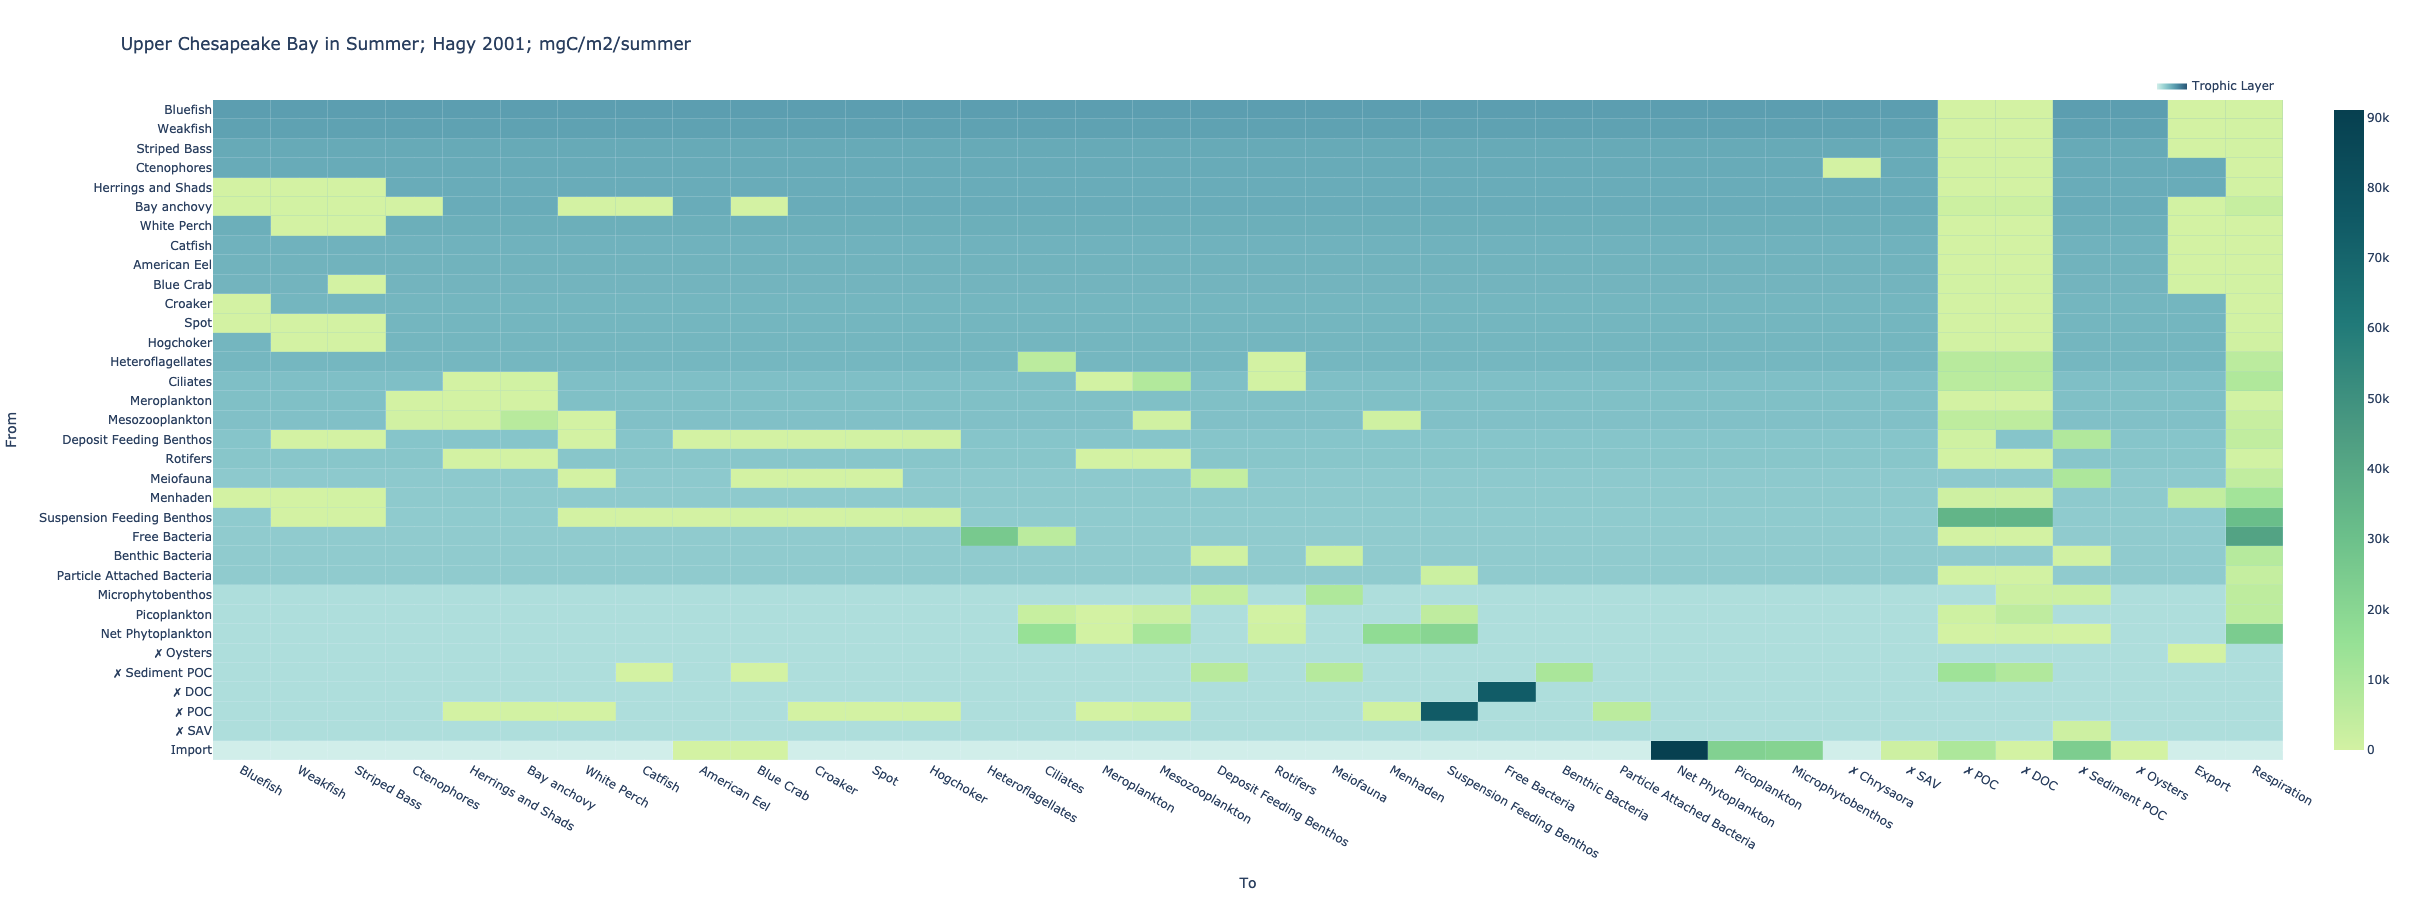

In [22]:
show_heatmap(food_webs[0], normalization=None, show_trophic_layer=True, add_external_flows=True, switch_axes=False)

### biomass

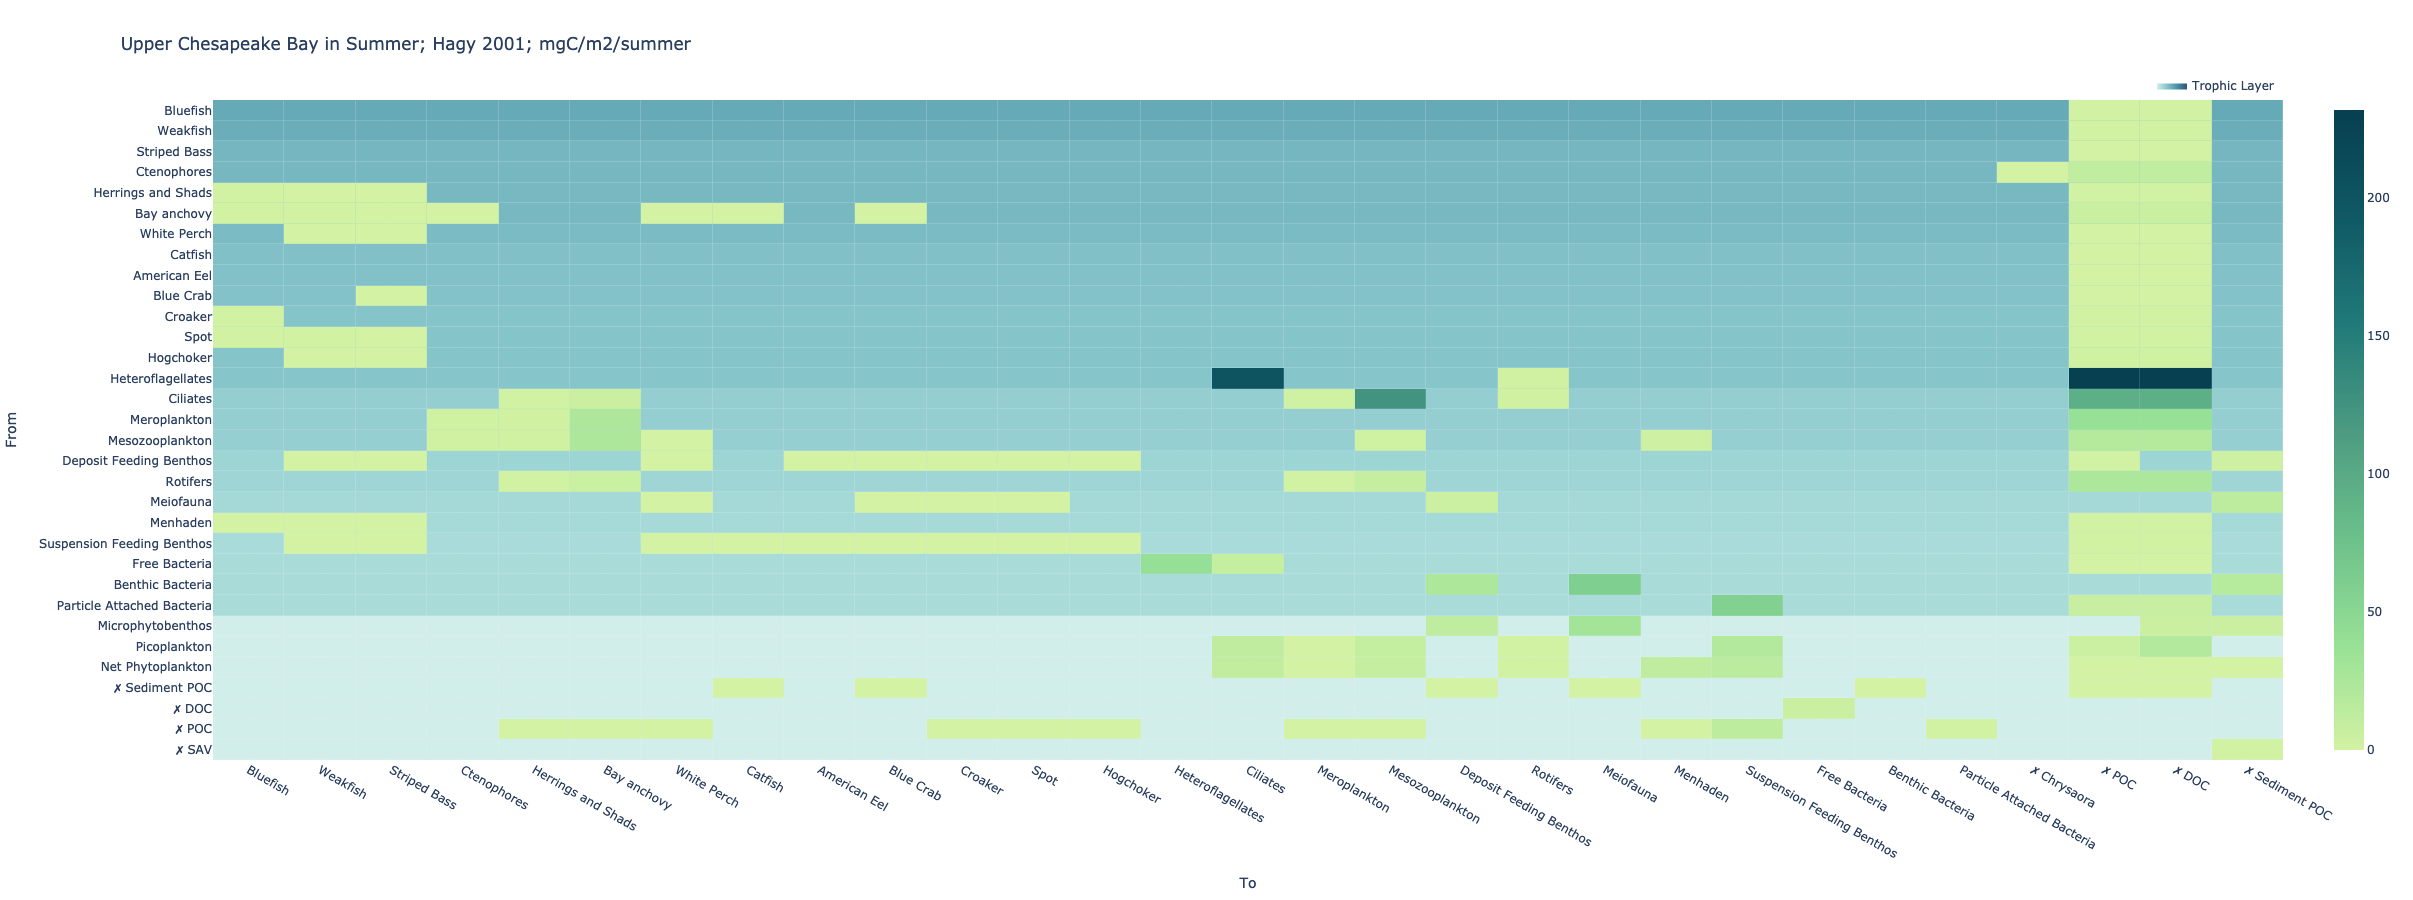

In [23]:
show_heatmap(food_webs[0], normalization='biomass', show_trophic_layer=True, add_external_flows=False)

### log

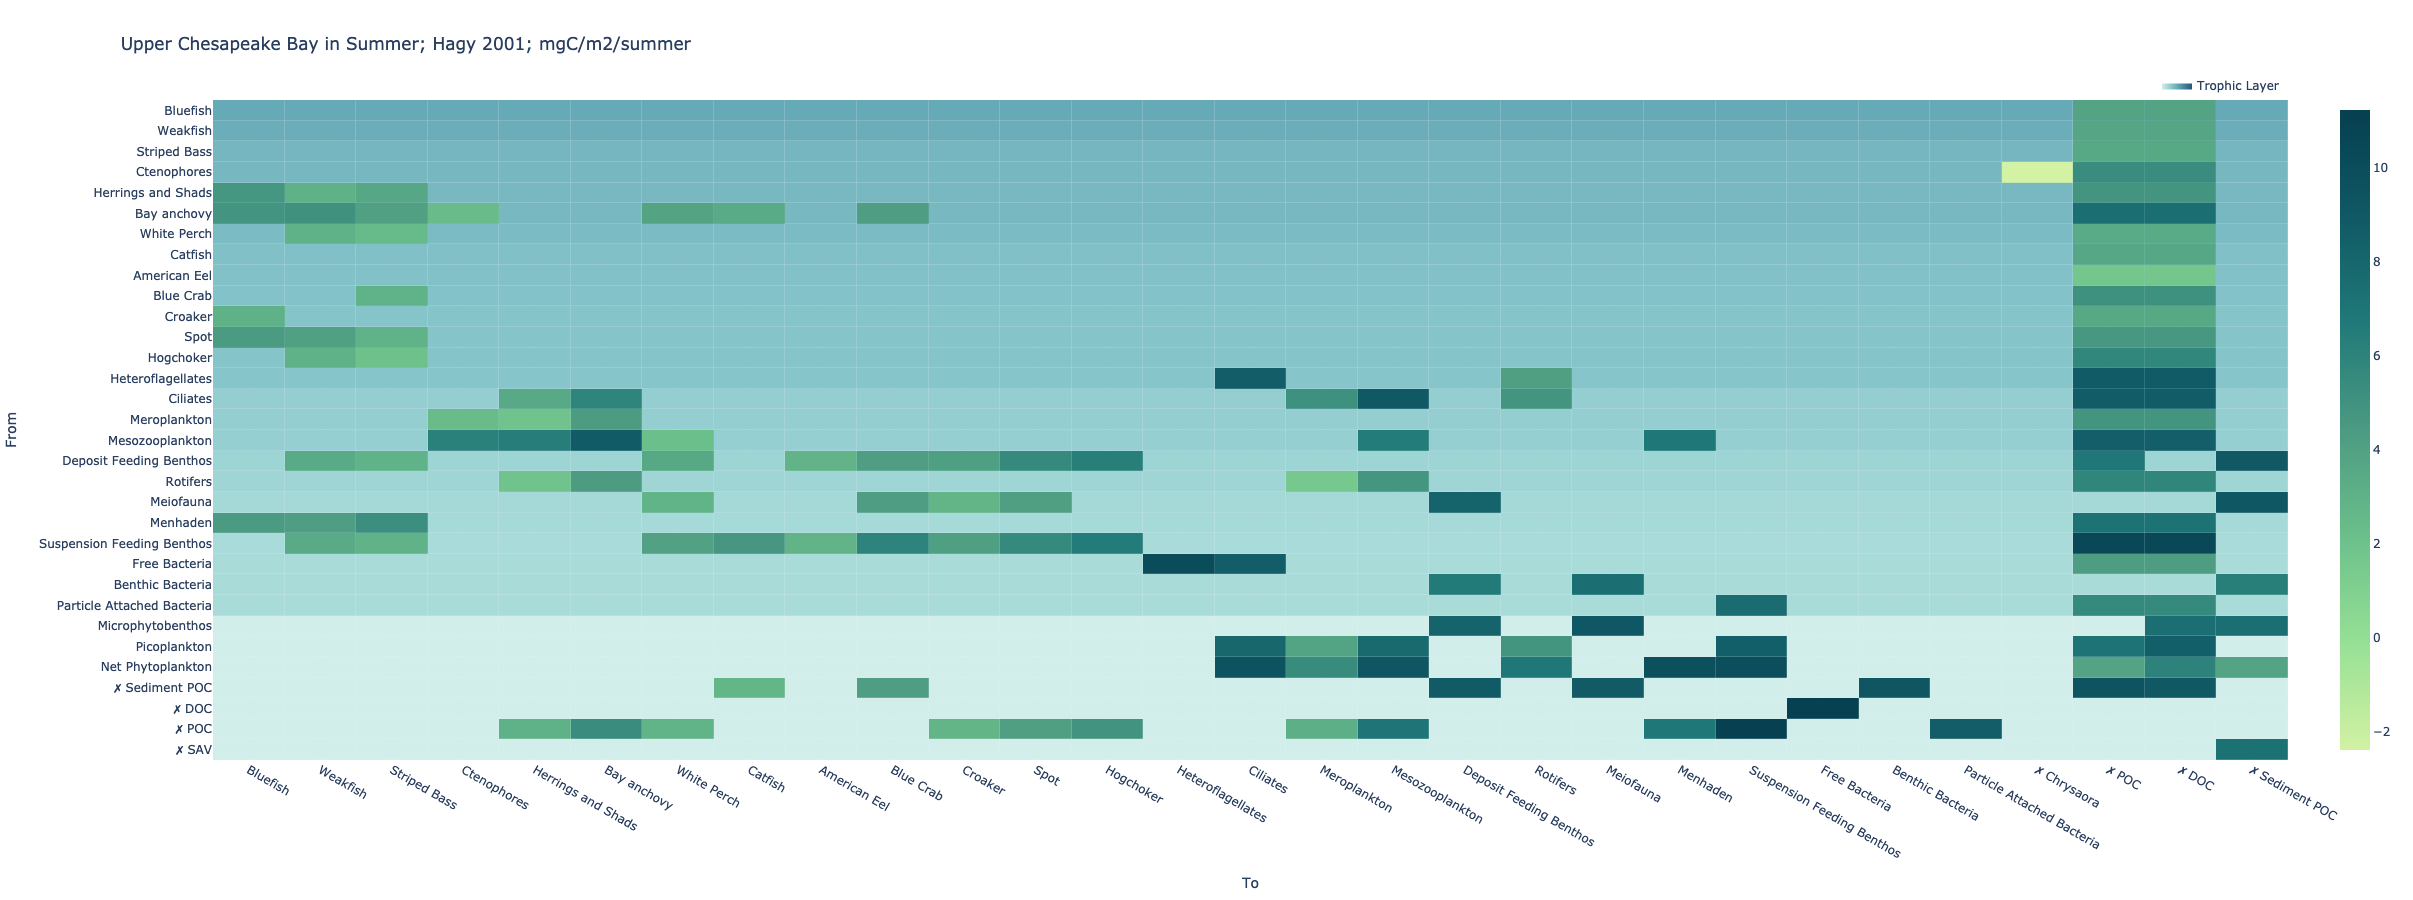

In [24]:
show_heatmap(food_webs[0], normalization='log', show_trophic_layer=True, add_external_flows=False)

### diet

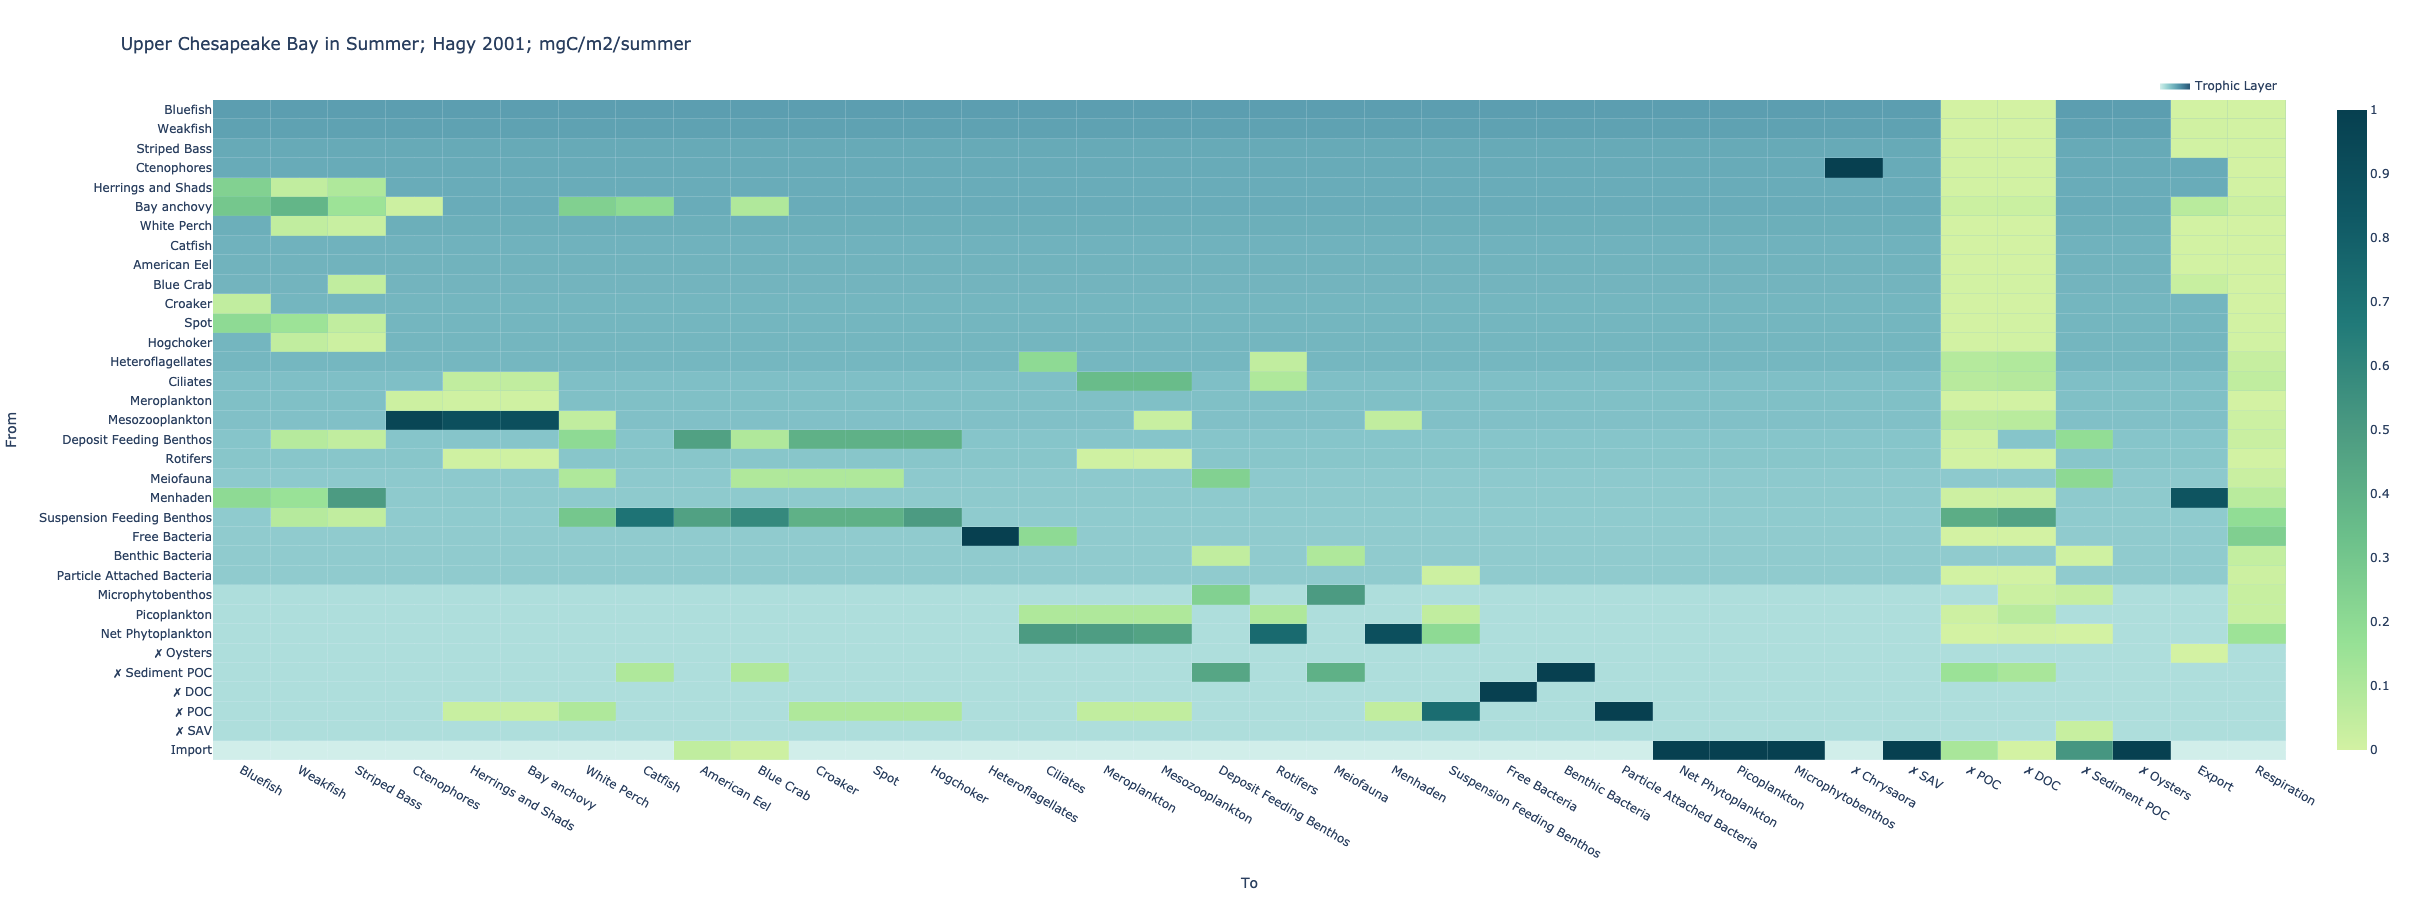

In [25]:
show_heatmap(food_webs[0], normalization='diet', show_trophic_layer=True, add_external_flows=True)

# dendogram?

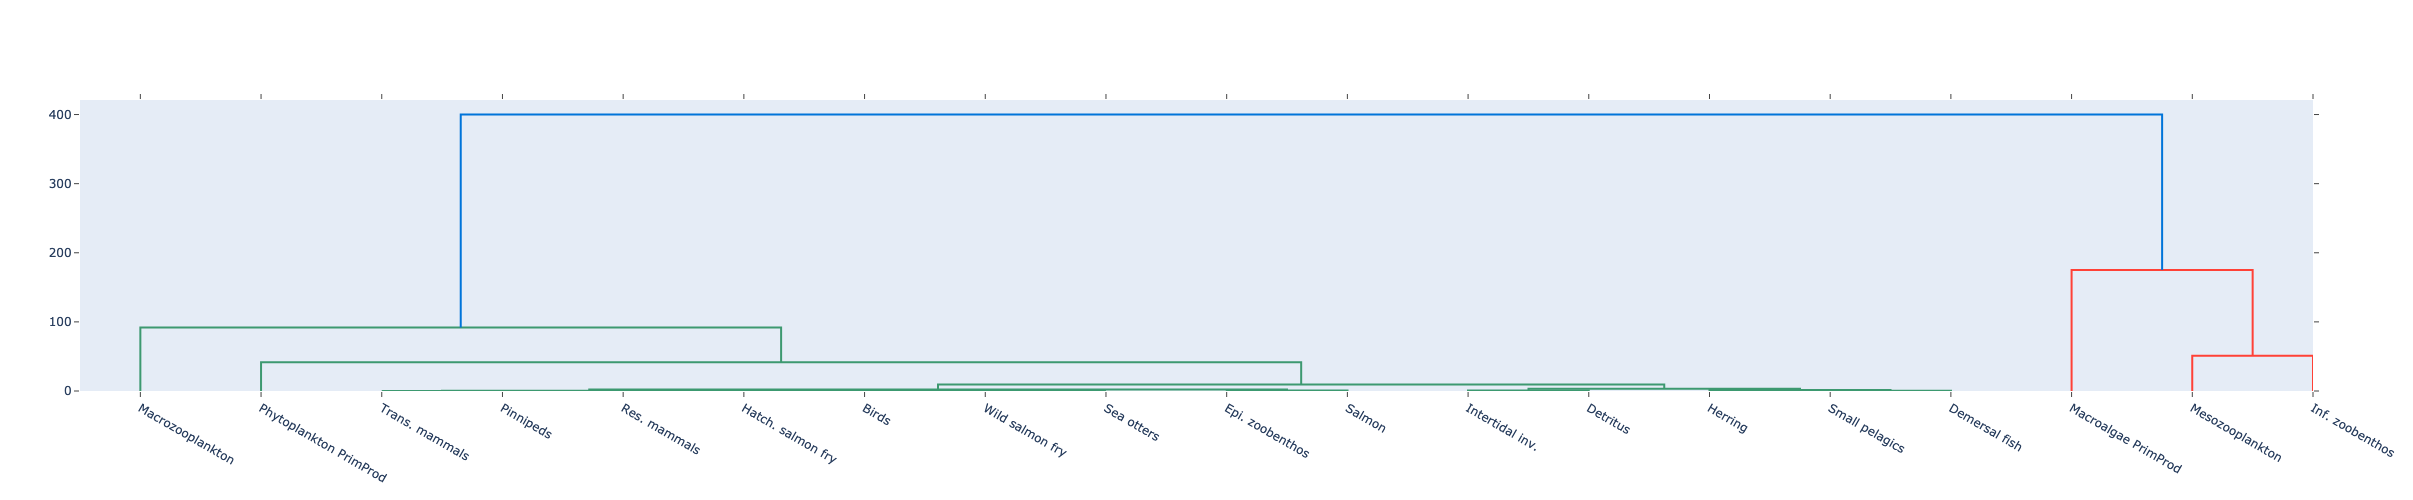

In [29]:
import plotly.figure_factory as ff
import numpy as np
np.random.seed(1)

net = food_webs[5]

fig = ff.create_dendrogram(np.array([[x] for x in net.nodeDF.Biomass.values]), labels=net.nodeDF.index.values)
fig.update_layout(width=800, height=500)
fig.show()

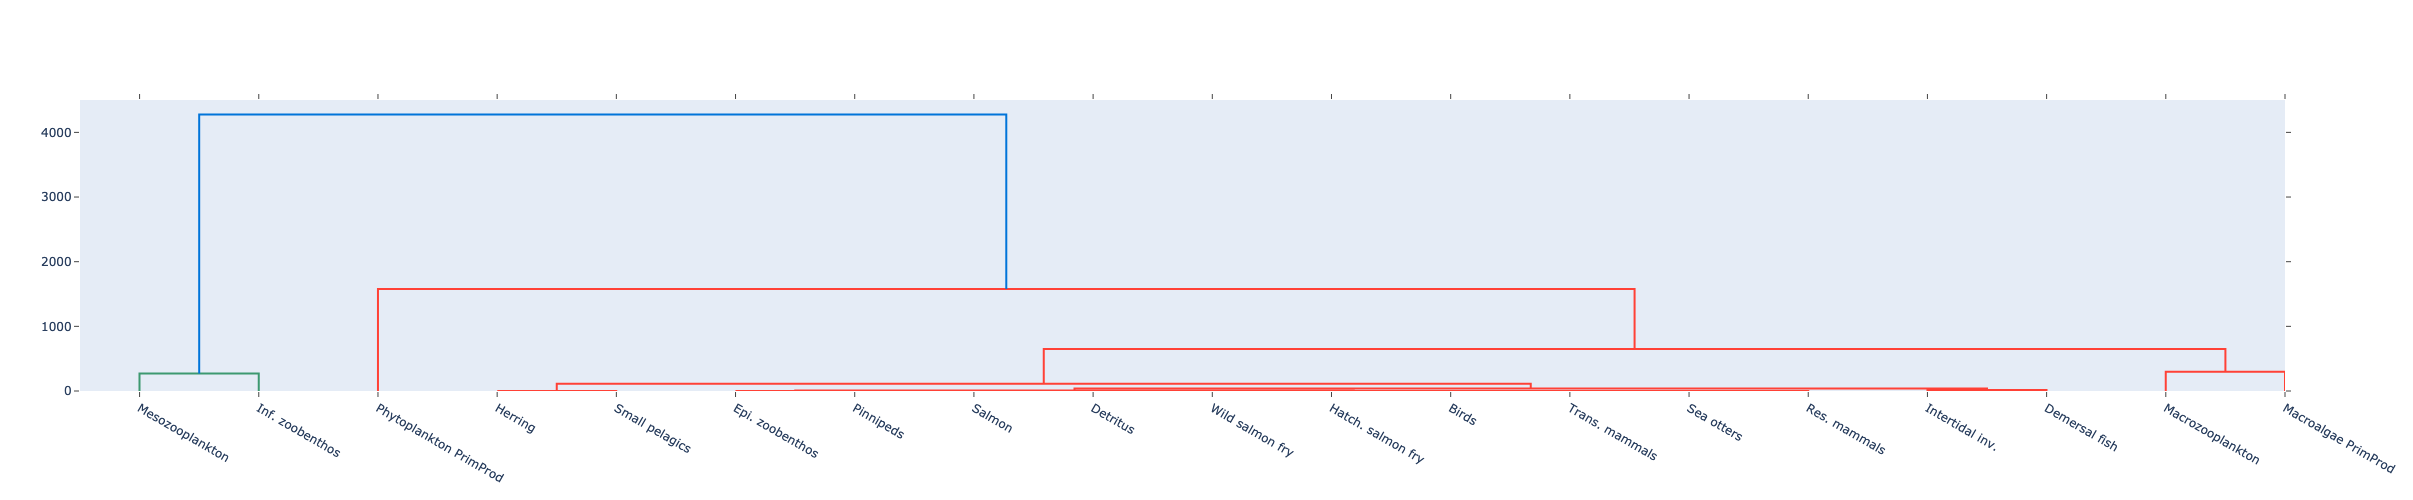

In [31]:
import plotly.figure_factory as ff
import numpy as np
np.random.seed(1)

net = food_webs[5]

fig = ff.create_dendrogram(np.array([[x] for x in net.nodeDF.Respiration.values]), labels=net.nodeDF.index.values)
fig.update_layout(width=800, height=500)
fig.show()

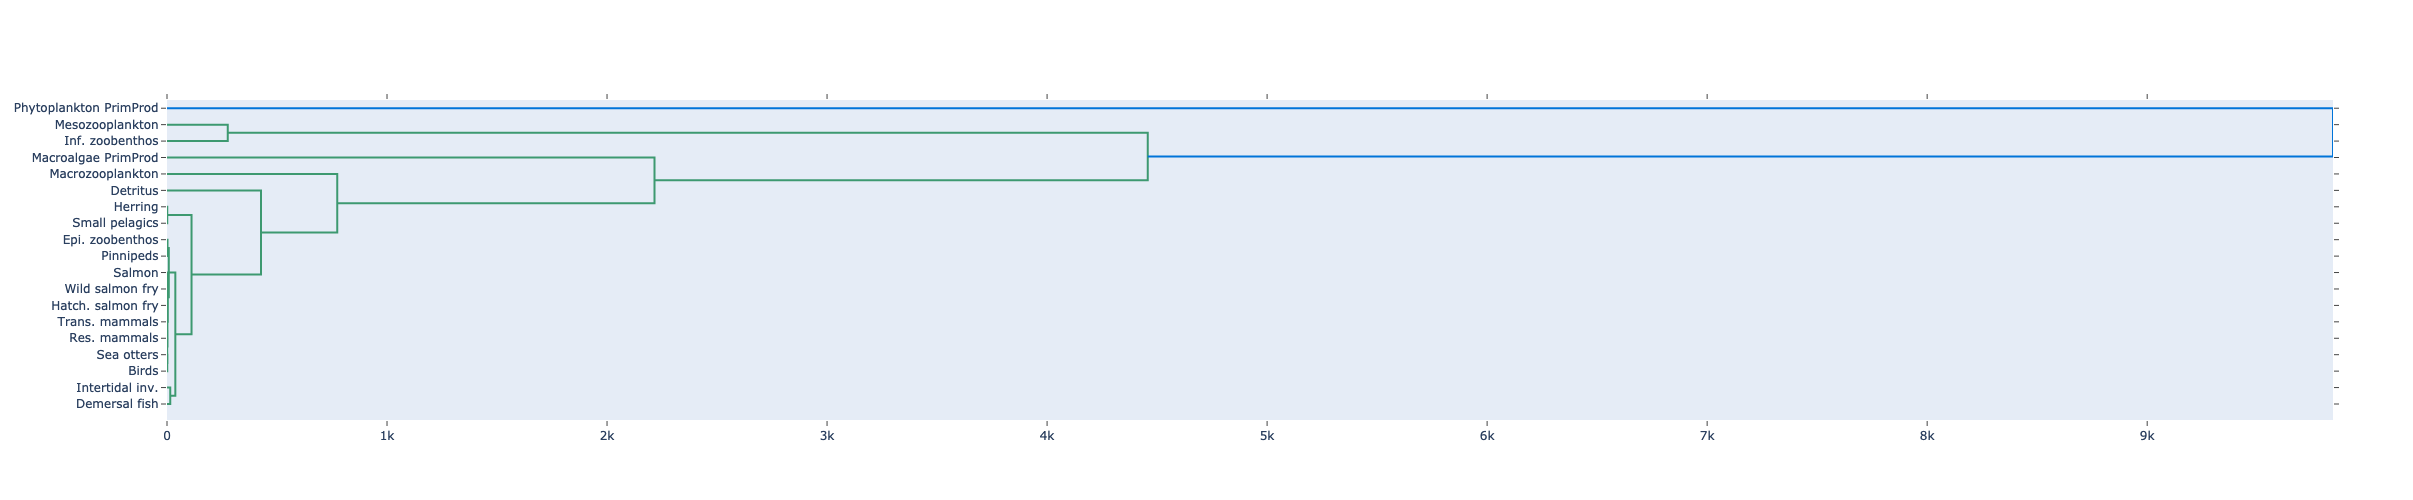

In [32]:
net = food_webs[5]

fig = ff.create_dendrogram(net.nodeDF[['Biomass', 'IsAlive', 'Import', 'Export', 'Respiration', 'TrophicLevel']].values, orientation='left', labels=net.nodeDF.index.values)
fig.update_layout(width=1200, height=500)
fig.show()